<a href="https://colab.research.google.com/github/MartinaJoergensen/FirstCodes/blob/master/MoritzTutorial6_GenModels(prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Normalize the dataset
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)
# merge test and training
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
del x_test, y_test

In [ ]:
print(x_train.shape, y_train.shape)

(70000, 28, 28, 1) (70000,)


In [ ]:
# Split training data into 50% train, 25% validation, 25% test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

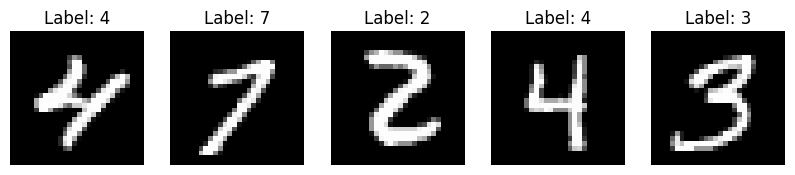

In [ ]:
# Visualize some digits from the dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(x_test[digits[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_test[digits[i]]}")
    ax.axis('off')
plt.show()

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(28, 28, 1))

# ----- Encoder -----
x = layers.Conv2D(64, (3, 3), use_bias=False,strides=2, padding='same')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(128, (3, 3), use_bias=False,strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(256, (3, 3), use_bias=False, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Dropout(0.1)(x)
# Flatten the output of the convolutional layers before passing to Dense layers
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary() # Uncomment to see the encoder summary

# --------------------------------------------------------
# Decoder
# --------------------------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 256))(x)

# Optimized Decoder Architecture:
# Upsample to 14x14
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Upsample to 28x28 (final output)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12544)          │        62,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,425 (1.37 MB)

 Trainable params: 359,169 (1.37 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # --------- MSE reconstruction loss ---------
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# [[[x],[y]],[[a],[b]]] ->[[x,y],[a,b]]

In [ ]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

# Train the autoencoder on the training data
history = vae.fit(mnist_digits, epochs=150, batch_size=128)

Epoch 1/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - kl_loss: 3.0888 - loss: 68.1794 - reconstruction_loss: 65.0906
Epoch 2/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - kl_loss: 6.1112 - loss: 36.6347 - reconstruction_loss: 30.5235
Epoch 3/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 6.6480 - loss: 34.6004 - reconstruction_loss: 27.9524
Epoch 4/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 6.9045 - loss: 33.5910 - reconstruction_loss: 26.6866
Epoch 5/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 7.1083 - loss: 32.9929 - reconstruction_loss: 25.8846
Epoch 6/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 7.2299 - loss: 32.5165 - reconstruction_loss: 25.2866
Epoch 7/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 7.3305 - loss: 32.0862 - reconstruction_loss: 24.7556
Epoch 8/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 7.4579 - loss: 31.7466 - reconstruction_loss: 24.2887
Epoch 9/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10m

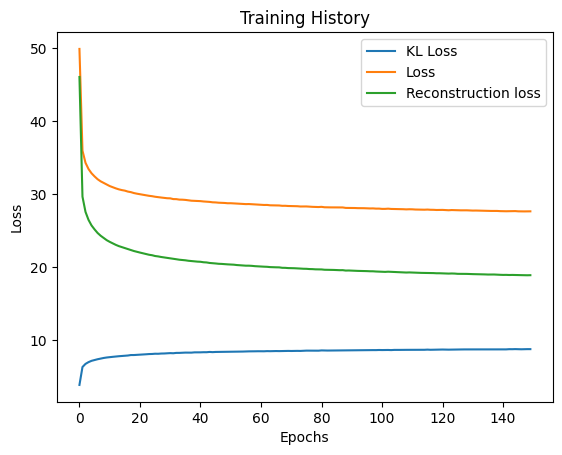

In [ ]:
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['reconstruction_loss'], label="Reconstruction loss")
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import os
def generate_random_images(decoder, latent_dim, n=10, store=False):
    # Sample random points in the latent space
    z_random = np.random.normal(size=(n, latent_dim))
    if store==True:
      os.makedirs("/content/generated", exist_ok=True)
    # Decode them into images
    generated = decoder.predict(z_random)

    # Plot
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = generated[i].squeeze()  # shape (28,28) or (28,28,1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()
    if store==True:
      for i in range(n):
        plt.figure()
        img = generated[i].squeeze()  # shape (28,28) or (28,28,1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.savefig(f'/content/generated/output_{i}.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


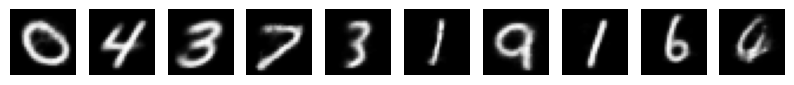

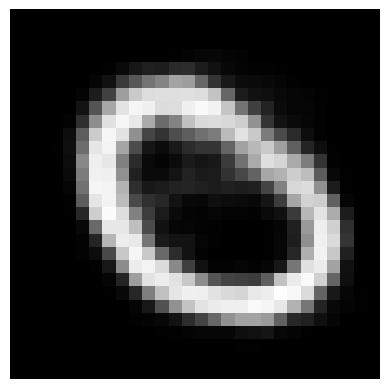

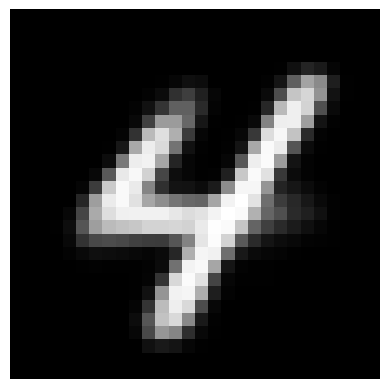

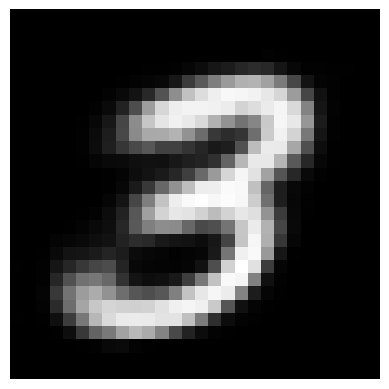

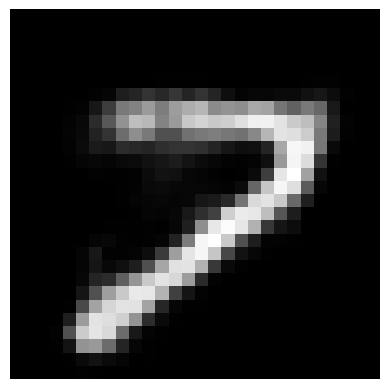

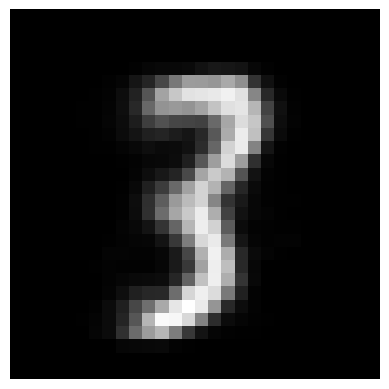

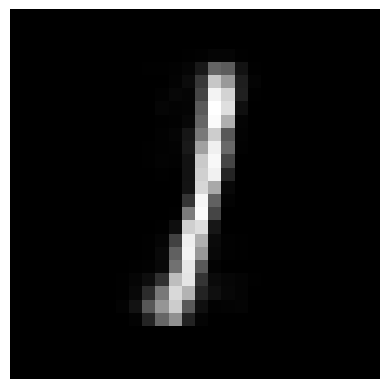

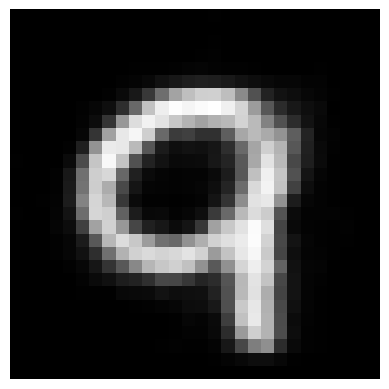

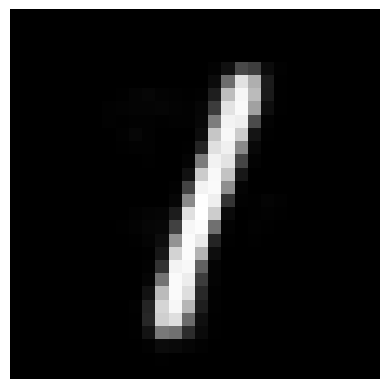

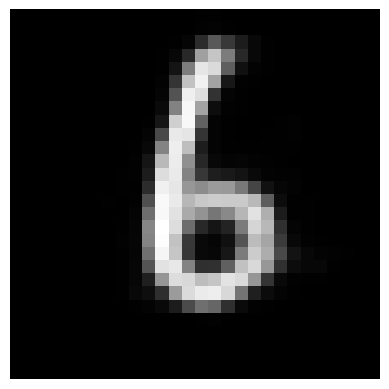

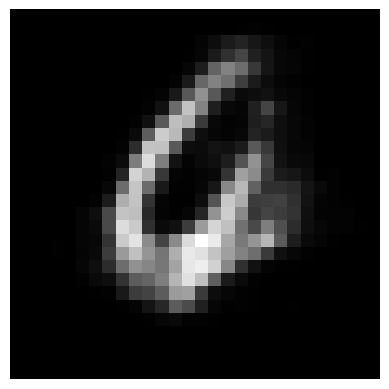

In [ ]:
generate_random_images(decoder, latent_dim=latent_dim, n=10, store=True)


## COMPARE FUNCTION OF TUT 3

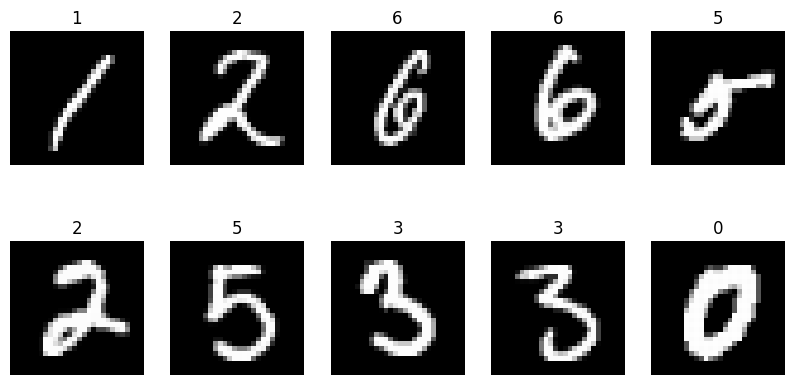

In [ ]:
# 1. Load the MNIST dataset
#(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

# Display a few sample images
class_names = [x for x in range(0,10)]

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(class_names[y_train[i]])
    plt.axis("off")
plt.show()

In [ ]:
# 4. Define a CNN classifier
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)


# Build a simple CNN model
model2 = tf.keras.Sequential([
    ##### Kernelsize = 7,7;
    tf.keras.layers.Conv2D(32, (5, 5), input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.MaxPooling2D((2, 2)),
    #####
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #####
    tf.keras.layers.Flatten(), #flatten the output to make it one dimensional;
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes for digits 0-9
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model2.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,986 (402.29 KB)

 Trainable params: 102,538 (400.54 KB)

 Non-trainable params: 448 (1.75 KB)

None


In [ ]:
# 5. Train the model (mini-batch)
# Train the model and store the history
history2 = model2.fit(x_train, y_train_cat, epochs=150, validation_data=(x_val, y_val_cat))

Epoch 1/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8175 - loss: 0.6020 - val_accuracy: 0.9717 - val_loss: 0.1529
Epoch 2/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9666 - loss: 0.1085 - val_accuracy: 0.9780 - val_loss: 0.1431
Epoch 3/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9748 - loss: 0.0855 - val_accuracy: 0.9811 - val_loss: 0.0845
Epoch 4/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9799 - loss: 0.0714 - val_accuracy: 0.9795 - val_loss: 0.0973
Epoch 5/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9816 - loss: 0.0658 - val_accuracy: 0.9830 - val_loss: 0.0834
Epoch 6/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9843 - loss: 0.0547 - val_accuracy: 0.9866 - val_loss: 0.0645
Epoch 7/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9859 - loss: 0.0482 - val_accuracy: 0.9869 - val_loss: 0.0558
Epoch 8/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9883 - loss

Image: output_0.png, Predicted Digit: 0


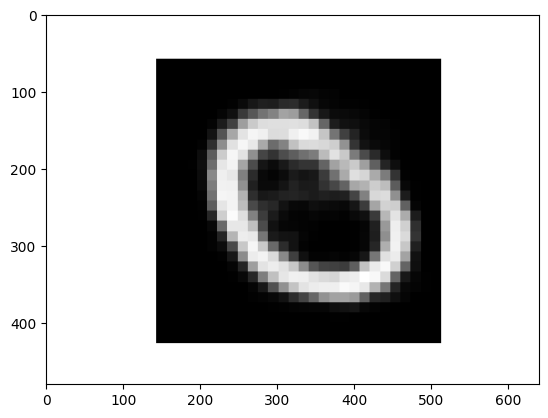

Image: output_1.png, Predicted Digit: 4


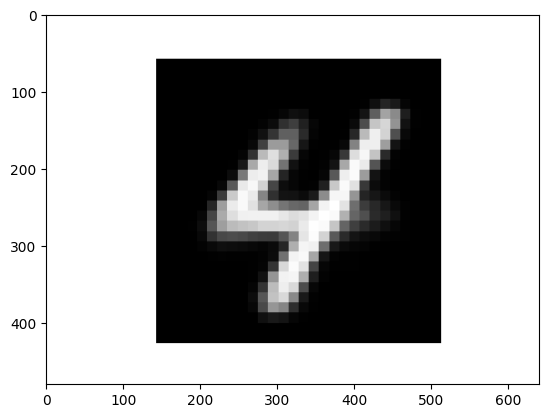

Image: output_2.png, Predicted Digit: 0


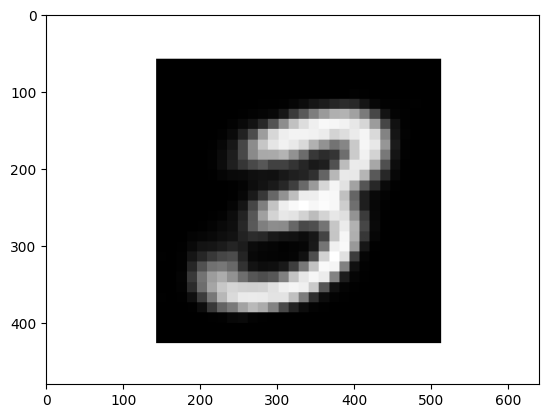

Image: output_3.png, Predicted Digit: 0


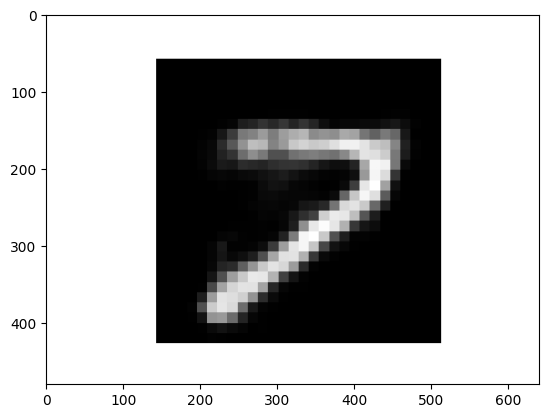

Image: output_4.png, Predicted Digit: 1


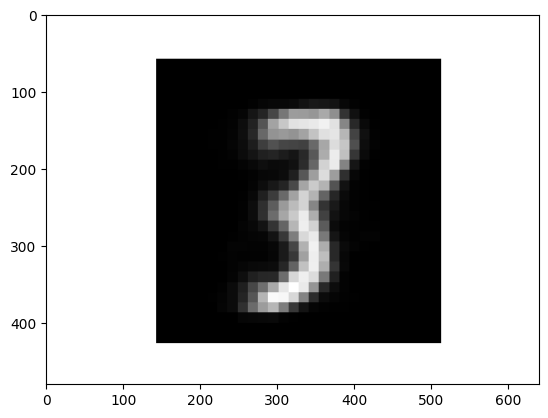

Image: output_5.png, Predicted Digit: 1


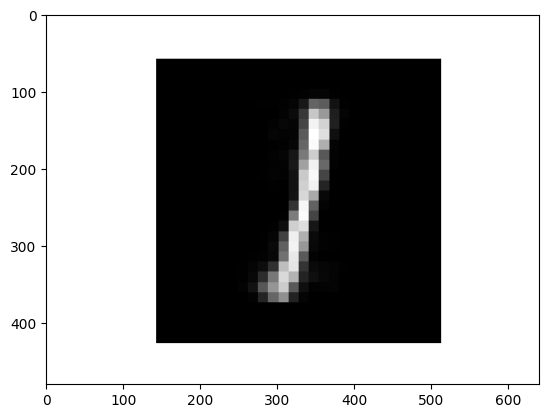

Image: output_6.png, Predicted Digit: 9


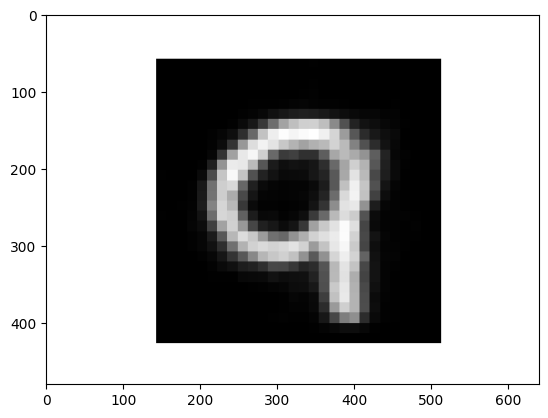

Image: output_7.png, Predicted Digit: 1


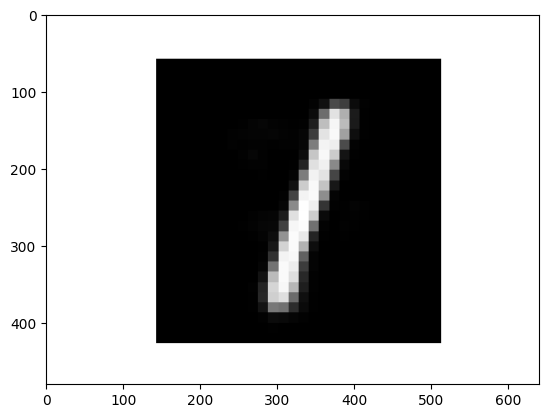

Image: output_8.png, Predicted Digit: 6


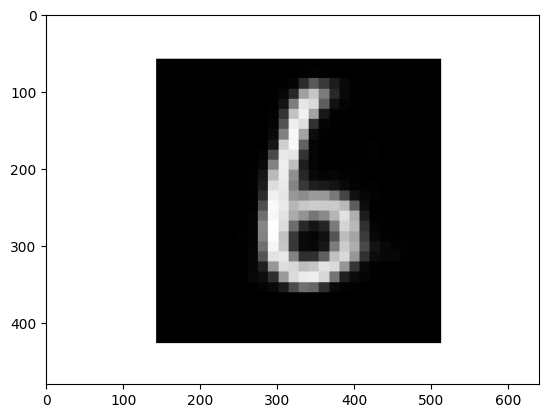

Image: output_9.png, Predicted Digit: 6


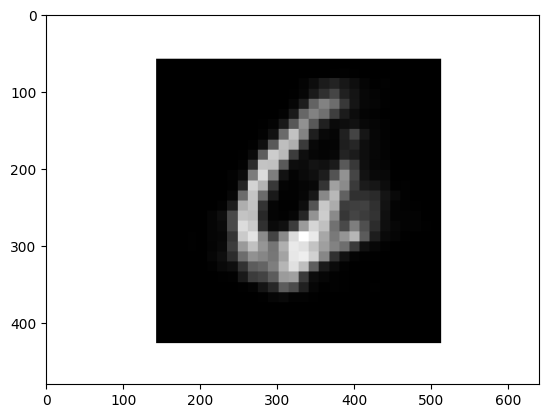

In [ ]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your generated images
generated_images_path = "/content/generated/"

# List all files in the directory
image_files = [f for f in os.listdir(generated_images_path)]


image_files.sort()

predictions = []
for img_name in image_files:
    img_path = os.path.join(generated_images_path, img_name)

    # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)



    # Resize to 28x28 (MNIST size)
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize pixel values to [0, 1]
    img = img.astype('float32') / 255.0

    # Add channel dimension (for grayscale, it's 1) and batch dimension
    img = np.expand_dims(img, axis=-1) # Becomes (28, 28, 1)
    img = np.expand_dims(img, axis=0)  # Becomes (1, 28, 28, 1) for batch

    # Make prediction
    prediction = model2.predict(img, verbose=0)
    # Get the predicted digit (class with highest probability)
    predicted_digit = np.argmax(prediction)

    predictions.append((img_name, predicted_digit))


for img_name, digit in predictions:
  img = mpimg.imread(f'{generated_images_path}/{img_name}')
  plt.imshow(img, label=digit)
  print(f"Image: {img_name}, Predicted Digit: {digit}")
  plt.show()

# GAN GENERATOR

In [ ]:
# ==========
# Hyperparameters
# ==========
latent_dim = 100
img_shape = (28, 28, 1)
batch_size = 128
epochs = 5  # change as you like


In [ ]:
# ==========
# Generator
# ========== #plain GAN
def build_generator(latent_dim):
    noise = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128)(noise)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((7, 7, 128))(x)

    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output: 28x28x1, values in [0,1] using sigmoid                   \/ <- PIXEL BY PIXEL
    img = layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")(x)

    return Model(noise, img, name="generator")

In [ ]:
# ==========
# Discriminator
# ==========
def build_discriminator(img_shape):
    img_input = layers.Input(shape=img_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(img_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU(0.2)(x)
    validity = layers.Dense(1, activation="sigmoid")(x)

    return Model(img_input, validity, name="discriminator")


In [ ]:
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

discriminator.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=["accuracy"],
)


In [ ]:
# ==========
# Combined model (Generator + frozen Discriminator)
# ==========
discriminator.trainable = False

z = layers.Input(shape=(latent_dim,))
img = generator(z)
valid = discriminator(img)

combined = Model(z, valid, name="combined")
combined.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
)

#just the casual def
# combined = Model(z, valid, name="combined")
# combined.compile(
#     loss="binary_crossentropy",
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
# )


In [ ]:
# ==========
# Training loop
# ==========

# Use your x_train from the split you did earlier
X_real = x_train.astype("float32")   # already in [0,1] and shape (28,28,1)

half_batch = batch_size // 2
steps_per_epoch = X_real.shape[0] // batch_size

for epoch in range(1, epochs + 1):
    for step in range(steps_per_epoch):

        # ---- Train Discriminator ----
        # Real images
        #shuffling
        idx = np.random.randint(0, X_real.shape[0], half_batch)
        real_imgs = X_real[idx]

        # Fake images
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        # Labels: real=1, fake=0
        real_y = np.ones((half_batch, 1))
        fake_y = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train Generator ----
        # Wants discriminator to think generated images are real (label=1)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))

        g_loss = combined.train_on_batch(noise, valid_y)

    print(f"Epoch {epoch}/{epochs} - D loss: {d_loss[0]}, D acc: {d_loss[1]*100}%, G loss: {g_loss}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/5 - D loss: 0.7853149771690369, D acc: 15.238327026367188%, G loss: 0.5736175179481506
Epoch 2/5 - D loss: 0.8536381721496582, D acc: 11.004068374633789%, G loss: 0.48439300060272217
Epoch 3/5 - D loss: 0.8814071416854858, D acc: 9.555344581604004%, G loss: 0.4498181641101837
Epoch 4/5 - D loss: 0.8962987661361694, D acc: 8.807534217834473%, G loss: 0.43167051672935486
Epoch 5/5 - D loss: 0.9059610366821289, D acc: 8.348599433898926%, G loss: 0.42009207606315613


In [ ]:
# ==========
# Generate some samples
# ==========
import matplotlib.pyplot as plt

def show_generated_images(generator, n=25):
    noise = np.random.normal(0, 1, (n, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)

    gen_imgs = gen_imgs.squeeze()  # (n, 28, 28)
    plt.figure(figsize=(5,5))
    for i in range(n):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
show_generated_images(generator, n=25)